<a href="https://colab.research.google.com/github/Hramchenko/ML/blob/master/conditional_fc_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip3 install torch torchvision
import torch

In [0]:
print("Device " + torch.cuda.get_device_name(0))
device = torch.device("cuda:0")
print(device)

Device Tesla K80
cuda:0


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
import os 

%matplotlib inline

In [0]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
           ])

def mnist(batch_size=50, valid=0, shuffle=True, transform=mnist_transform, path='./MNIST_data'):
    test_data = datasets.MNIST(path, train=False, download=True, transform=transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    train_data = datasets.MNIST(path, train=True, download=True, transform=transform)
    if valid > 0:
        num_train = len(train_data)
        indices = list(range(num_train))
        split = num_train-valid
        np.random.shuffle(indices)

        train_idx, valid_idx = indices[:split], indices[split:]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
        valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
    
        return train_loader, valid_loader, test_loader
    else:
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
        return train_loader, test_loader


def plot_mnist(images, shape, show=True, save_to=None):
    fig = plt.figure(figsize=shape[::-1], dpi=80)
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))

    if save_to is not None:
        plt.savefig(save_to)
        
    if show:
        plt.show()
    else:
        plt.close()

    
def plot_graphs(log, tpe='loss'):
    keys = log.keys()
    logs = {k:[z for z in zip(*log[k])] for k in keys}
    epochs = {k:range(len(log[k])) for k in keys}
    
    if tpe == 'loss':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][0], label=k) for k in keys])
        plt.title('errors')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.legend(handles=handlers)
        plt.show()
    elif tpe == 'accuracy':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][1], label=k) for k in log.keys()])
        plt.title('accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(handles=handlers)
        plt.show()
        
def to_onehot(x, n, device=None):
    if isinstance(x, np.ndarray):
        x = torch.Tensor(x).to(torch.long)
    one_hot = torch.zeros((x.shape[0], n))
    one_hot.scatter_(1, x[:, None], 1.)
    if device is not None:
        one_hot = one_hot.to(device)
    return one_hot        

In [0]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [0]:
root_folder = 'FC_GAN_results'
fixed_folder = root_folder + '/Fixed_results'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)

In [0]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

In [0]:
lr = 0.0001
prior_size = 100
train_epoch = 1000
batch_size = 250
train_loader, valid_loader, test_loader = mnist(batch_size=batch_size, valid=10000, transform=mnist_tanh)
fixed_z = torch.randn((10, 100))

In [0]:
fixed_z_ = torch.cat([fixed_z.flatten(1), to_onehot(torch.LongTensor(np.linspace(0, 9, 10)), 10)], dim=1)
fixed_z_.shape

torch.Size([10, 110])

In [0]:
torch.LongTensor(np.linspace(0, 9, 10))
to_onehot(torch.LongTensor(np.linspace(0, 9, 10)), 10).shape

torch.Size([10, 10])

In [0]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, last_fn=None):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        return self.model(x)

In [0]:
G = FullyConnected([prior_size+10, 256, 512, 1024, 28*28], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh()).to(device)
D = FullyConnected([28*28+10, 1024, 512, 256, 1], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), flatten=True).to(device)

G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)

In [0]:
train_log = {'G': [], 'D': []}
test_log = {'G': [], 'D': []}

In [0]:
batch_zeros = torch.zeros((batch_size, 1)).to(device)
batch_ones = torch.ones((batch_size, 1)).to(device)

In [0]:
for batch_idx, (data, target) in enumerate(train_loader):
  print (data.flatten(1).shape)
  print(target)
  print(to_onehot(target, 10).shape)
  
  N = torch.cat([data.flatten(1), to_onehot(target, 10)], dim=1)
  print(N)
  break

torch.Size([250, 784])
tensor([1, 5, 0, 8, 4, 8, 4, 7, 9, 5, 5, 0, 4, 3, 4, 6, 8, 8, 6, 7, 9, 9, 6, 2,
        3, 8, 1, 1, 7, 4, 5, 1, 2, 8, 9, 8, 3, 1, 7, 7, 1, 0, 2, 7, 6, 1, 8, 8,
        1, 7, 2, 0, 8, 2, 6, 3, 7, 3, 4, 6, 0, 5, 4, 2, 5, 4, 4, 5, 6, 3, 5, 0,
        5, 4, 4, 7, 2, 4, 9, 3, 9, 2, 7, 8, 9, 8, 0, 4, 7, 4, 3, 7, 8, 2, 6, 9,
        3, 4, 3, 7, 2, 8, 2, 6, 6, 4, 2, 6, 9, 5, 8, 8, 5, 8, 0, 3, 1, 9, 5, 4,
        2, 9, 6, 7, 6, 6, 2, 7, 4, 1, 5, 2, 7, 6, 5, 2, 0, 7, 0, 6, 1, 1, 1, 3,
        5, 1, 0, 8, 8, 6, 2, 3, 5, 3, 9, 5, 7, 2, 4, 7, 0, 5, 4, 8, 4, 1, 8, 0,
        9, 6, 0, 6, 7, 6, 1, 1, 2, 3, 8, 9, 9, 9, 1, 5, 6, 4, 4, 4, 9, 1, 1, 3,
        5, 4, 7, 4, 4, 6, 1, 7, 8, 6, 1, 9, 8, 0, 5, 0, 9, 0, 6, 8, 9, 4, 4, 6,
        1, 1, 3, 1, 9, 1, 1, 0, 0, 7, 2, 4, 2, 6, 9, 5, 7, 0, 3, 8, 9, 0, 2, 9,
        0, 9, 6, 0, 3, 9, 7, 8, 4, 6])
torch.Size([250, 10])
tensor([[-1., -1., -1.,  ...,  0.,  0.,  0.],
        [-1., -1., -1.,  ...,  0.,  0.,  0.],
        [-1., -1., -1., 

In [0]:
def train(epoch, G, D, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        # train D
        D.zero_grad()
        G.zero_grad()
        z = torch.randn((batch_size, prior_size))
        
        oh = to_onehot(target, 10)
        
        data_ = torch.cat([data.flatten(1), oh], dim=1)
        z_ = torch.cat([torch.randn((batch_size, prior_size)), oh], dim=1)
        g_ = torch.cat([G(z_.to(device)), oh.to(device)], dim=1)

        fake_pred = D(g_.to(device))
        true_pred = D(data_.to(device))
        
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        
        D_loss = 0.5*(fake_loss + true_loss)
        
        D_loss.backward()
        D_optimizer.step()
        
        # train G
        D.zero_grad()
        G.zero_grad()
        z = torch.randn((batch_size, prior_size))
        
        ohg = to_onehot(torch.randint(0, 10, (batch_size,)), 10)
        z_ = torch.cat([torch.randn((batch_size, prior_size)), ohg], dim=1)
        g_ = torch.cat([G(z_.to(device)), ohg.to(device)], dim=1)
        fake_pred = D(g_.to(device))
        G_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_ones)
        
        G_loss.backward()
        
        G_optimizer.step()
            
        if batch_idx % 100 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = 'G: {:.4f}, D: {:.4f}'.format(G_loss.item(), D_loss.item())
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = 'G: {:.4f}, D: {:.4f}'.format(G_loss.item(), D_loss.item())
        print(line + losses)
        log['G'].append(G_loss.item())
        log['D'].append(D_loss.item())

In [0]:
def test(G, D, loader, epoch, log=None):
    test_size = len(loader)
    G_loss = 0.
    D_loss = 0.
    test_loss = {'G': 0., 'D': 0.}
    with torch.no_grad():
        for data, target in loader:
            oh = to_onehot(target, 10)
            z = torch.randn((batch_size, prior_size))
            data_ = torch.cat([data.flatten(1), oh], dim=1)
            z_ = torch.cat([torch.randn((batch_size, prior_size)), oh], dim=1)
            g_ = torch.cat([G(z_.to(device)), oh.to(device)], dim=1)
            
            fake_pred = D(g_.to(device))
            true_pred = D(data_.to(device))
        
            fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros).item()
            true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones).item()
            
            D_loss += 0.5*(fake_loss + true_loss)
            G_loss += F.binary_cross_entropy_with_logits(fake_pred, batch_ones).item()
    
    G_loss /= test_size
    D_loss /= test_size

    fg = G(fixed_z_.to(device))
    fixed_gen = fg.cpu().data.numpy().reshape(10, 1, 28, 28)
    plot_mnist(fixed_gen, (1, 10), True, fixed_folder + '/%03d.png' % epoch)
    report = 'Test losses. G: {:.4f}, D: {:.4f}'.format(G_loss, D_loss)
    print(report)

Train Epoch: 1 [0/50000 (0%)]	Losses G: 3.0855, D: 0.1784
Train Epoch: 1 [25000/50000 (50%)]	Losses G: 3.3873, D: 0.2935
Train Epoch: 1 [50000/50000 (100%)]	Losses G: 2.7167, D: 0.2930


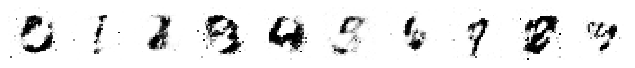

Test losses. G: 2.7426, D: 0.2027
Train Epoch: 2 [0/50000 (0%)]	Losses G: 2.7750, D: 0.2633
Train Epoch: 2 [25000/50000 (50%)]	Losses G: 2.9354, D: 0.3422
Train Epoch: 2 [50000/50000 (100%)]	Losses G: 2.8779, D: 0.2797


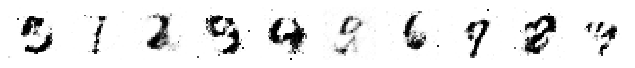

Test losses. G: 2.7248, D: 0.2107
Train Epoch: 3 [0/50000 (0%)]	Losses G: 2.9431, D: 0.2850
Train Epoch: 3 [25000/50000 (50%)]	Losses G: 3.2113, D: 0.3331
Train Epoch: 3 [50000/50000 (100%)]	Losses G: 2.7761, D: 0.3168


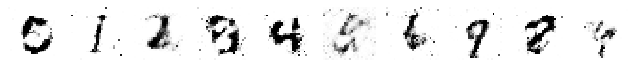

Test losses. G: 2.5638, D: 0.2872
Train Epoch: 4 [0/50000 (0%)]	Losses G: 2.4795, D: 0.3519
Train Epoch: 4 [25000/50000 (50%)]	Losses G: 2.3115, D: 0.3013
Train Epoch: 4 [50000/50000 (100%)]	Losses G: 2.8716, D: 0.2006


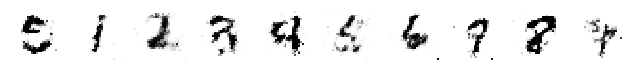

Test losses. G: 2.7321, D: 0.1528
Train Epoch: 5 [0/50000 (0%)]	Losses G: 2.8505, D: 0.1994
Train Epoch: 5 [25000/50000 (50%)]	Losses G: 2.5802, D: 0.3150
Train Epoch: 5 [50000/50000 (100%)]	Losses G: 2.7925, D: 0.2566


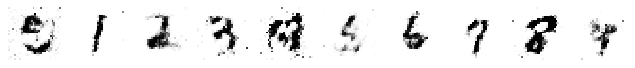

Test losses. G: 2.7396, D: 0.2033
Train Epoch: 6 [0/50000 (0%)]	Losses G: 2.6848, D: 0.2842
Train Epoch: 6 [25000/50000 (50%)]	Losses G: 2.8920, D: 0.2981
Train Epoch: 6 [50000/50000 (100%)]	Losses G: 2.6324, D: 0.3320


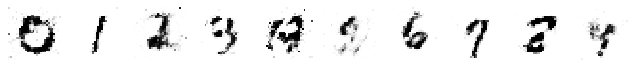

Test losses. G: 2.3928, D: 0.2320
Train Epoch: 7 [0/50000 (0%)]	Losses G: 2.1926, D: 0.3041
Train Epoch: 7 [25000/50000 (50%)]	Losses G: 2.2650, D: 0.3680
Train Epoch: 7 [50000/50000 (100%)]	Losses G: 2.6748, D: 0.3133


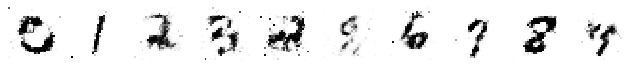

Test losses. G: 2.3286, D: 0.1809
Train Epoch: 8 [0/50000 (0%)]	Losses G: 2.9343, D: 0.2509
Train Epoch: 8 [25000/50000 (50%)]	Losses G: 2.4273, D: 0.3013
Train Epoch: 8 [50000/50000 (100%)]	Losses G: 1.8719, D: 0.3710


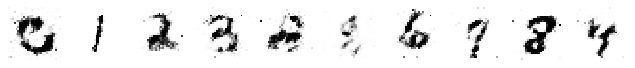

Test losses. G: 1.9615, D: 0.2414
Train Epoch: 9 [0/50000 (0%)]	Losses G: 1.9315, D: 0.2868
Train Epoch: 9 [25000/50000 (50%)]	Losses G: 2.2960, D: 0.2125
Train Epoch: 9 [50000/50000 (100%)]	Losses G: 2.4958, D: 0.2648


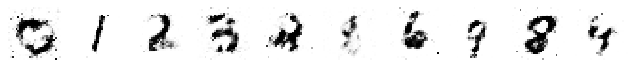

Test losses. G: 2.5858, D: 0.2257
Train Epoch: 10 [0/50000 (0%)]	Losses G: 2.5721, D: 0.3444
Train Epoch: 10 [25000/50000 (50%)]	Losses G: 2.6582, D: 0.2929
Train Epoch: 10 [50000/50000 (100%)]	Losses G: 2.2050, D: 0.3034


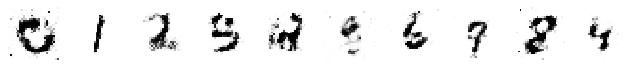

Test losses. G: 2.2912, D: 0.2234
Train Epoch: 11 [0/50000 (0%)]	Losses G: 2.4681, D: 0.2975
Train Epoch: 11 [25000/50000 (50%)]	Losses G: 2.4533, D: 0.2642
Train Epoch: 11 [50000/50000 (100%)]	Losses G: 2.2022, D: 0.2172


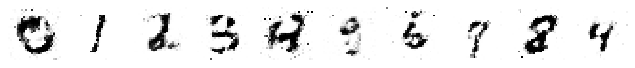

Test losses. G: 2.1699, D: 0.1867
Train Epoch: 12 [0/50000 (0%)]	Losses G: 2.8513, D: 0.2682
Train Epoch: 12 [25000/50000 (50%)]	Losses G: 2.5133, D: 0.3611
Train Epoch: 12 [50000/50000 (100%)]	Losses G: 2.1585, D: 0.4509


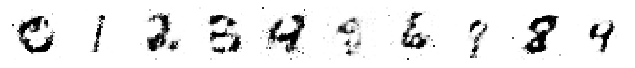

Test losses. G: 2.0711, D: 0.2847
Train Epoch: 13 [0/50000 (0%)]	Losses G: 1.9020, D: 0.3540
Train Epoch: 13 [25000/50000 (50%)]	Losses G: 2.5132, D: 0.3017
Train Epoch: 13 [50000/50000 (100%)]	Losses G: 2.6030, D: 0.3603


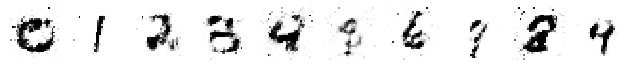

Test losses. G: 2.5074, D: 0.2403
Train Epoch: 14 [0/50000 (0%)]	Losses G: 2.3929, D: 0.3201
Train Epoch: 14 [25000/50000 (50%)]	Losses G: 2.2933, D: 0.3511
Train Epoch: 14 [50000/50000 (100%)]	Losses G: 2.1008, D: 0.3693


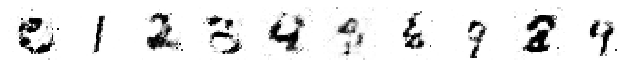

Test losses. G: 2.0311, D: 0.3003
Train Epoch: 15 [0/50000 (0%)]	Losses G: 1.9451, D: 0.3973
Train Epoch: 15 [25000/50000 (50%)]	Losses G: 2.3696, D: 0.3657
Train Epoch: 15 [50000/50000 (100%)]	Losses G: 2.0690, D: 0.3670


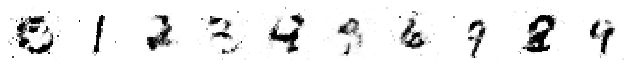

Test losses. G: 2.0545, D: 0.2880
Train Epoch: 16 [0/50000 (0%)]	Losses G: 1.9328, D: 0.3644
Train Epoch: 16 [25000/50000 (50%)]	Losses G: 2.0084, D: 0.2961
Train Epoch: 16 [50000/50000 (100%)]	Losses G: 2.4550, D: 0.3247


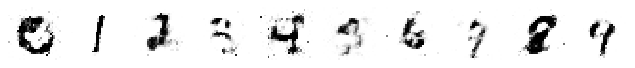

Test losses. G: 2.3011, D: 0.2207
Train Epoch: 17 [0/50000 (0%)]	Losses G: 2.6160, D: 0.2828
Train Epoch: 17 [25000/50000 (50%)]	Losses G: 2.4187, D: 0.3516
Train Epoch: 17 [50000/50000 (100%)]	Losses G: 2.1698, D: 0.3619


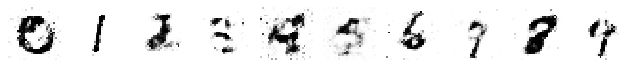

Test losses. G: 1.9749, D: 0.2979
Train Epoch: 18 [0/50000 (0%)]	Losses G: 2.2327, D: 0.4131
Train Epoch: 18 [25000/50000 (50%)]	Losses G: 2.3809, D: 0.3455
Train Epoch: 18 [50000/50000 (100%)]	Losses G: 2.3713, D: 0.3784


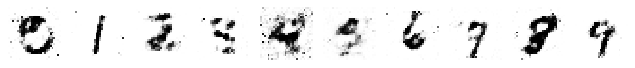

Test losses. G: 2.3390, D: 0.3141
Train Epoch: 19 [0/50000 (0%)]	Losses G: 2.2393, D: 0.4493
Train Epoch: 19 [25000/50000 (50%)]	Losses G: 1.9382, D: 0.3744
Train Epoch: 19 [50000/50000 (100%)]	Losses G: 2.4243, D: 0.2934


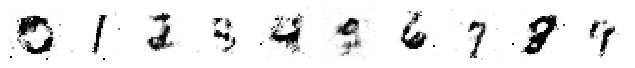

Test losses. G: 2.4473, D: 0.2467
Train Epoch: 20 [0/50000 (0%)]	Losses G: 2.1111, D: 0.3235
Train Epoch: 20 [25000/50000 (50%)]	Losses G: 2.2249, D: 0.3592
Train Epoch: 20 [50000/50000 (100%)]	Losses G: 1.7799, D: 0.3703


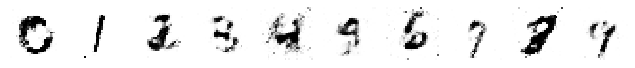

Test losses. G: 1.7410, D: 0.2864
Train Epoch: 21 [0/50000 (0%)]	Losses G: 1.9796, D: 0.3731
Train Epoch: 21 [25000/50000 (50%)]	Losses G: 1.9261, D: 0.3290
Train Epoch: 21 [50000/50000 (100%)]	Losses G: 2.2593, D: 0.3189


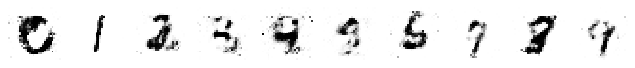

Test losses. G: 2.2364, D: 0.2910
Train Epoch: 22 [0/50000 (0%)]	Losses G: 2.1890, D: 0.3636
Train Epoch: 22 [25000/50000 (50%)]	Losses G: 2.1304, D: 0.3617
Train Epoch: 22 [50000/50000 (100%)]	Losses G: 2.1781, D: 0.3533


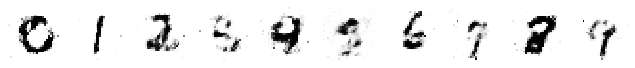

Test losses. G: 2.2044, D: 0.2937
Train Epoch: 23 [0/50000 (0%)]	Losses G: 2.1429, D: 0.3837
Train Epoch: 23 [25000/50000 (50%)]	Losses G: 1.8948, D: 0.3757
Train Epoch: 23 [50000/50000 (100%)]	Losses G: 1.8202, D: 0.4276


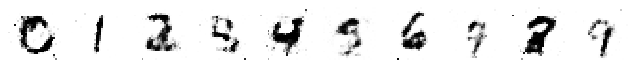

Test losses. G: 1.8726, D: 0.3166
Train Epoch: 24 [0/50000 (0%)]	Losses G: 1.9812, D: 0.3801
Train Epoch: 24 [25000/50000 (50%)]	Losses G: 1.8650, D: 0.4270
Train Epoch: 24 [50000/50000 (100%)]	Losses G: 1.8037, D: 0.5009


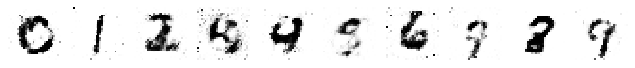

Test losses. G: 1.6380, D: 0.3748
Train Epoch: 25 [0/50000 (0%)]	Losses G: 1.7288, D: 0.4526
Train Epoch: 25 [25000/50000 (50%)]	Losses G: 1.9051, D: 0.4294
Train Epoch: 25 [50000/50000 (100%)]	Losses G: 1.8827, D: 0.3686


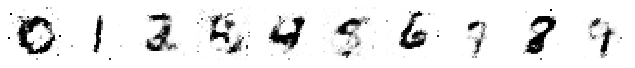

Test losses. G: 1.8856, D: 0.3107
Train Epoch: 26 [0/50000 (0%)]	Losses G: 1.9416, D: 0.4091
Train Epoch: 26 [25000/50000 (50%)]	Losses G: 2.5103, D: 0.2988
Train Epoch: 26 [50000/50000 (100%)]	Losses G: 1.9102, D: 0.2990


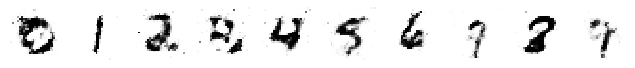

Test losses. G: 1.9252, D: 0.2427
Train Epoch: 27 [0/50000 (0%)]	Losses G: 2.2080, D: 0.3173
Train Epoch: 27 [25000/50000 (50%)]	Losses G: 1.7745, D: 0.4107
Train Epoch: 27 [50000/50000 (100%)]	Losses G: 1.6812, D: 0.4307


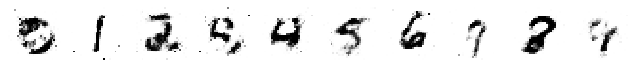

Test losses. G: 1.7360, D: 0.3316
Train Epoch: 28 [0/50000 (0%)]	Losses G: 1.7259, D: 0.4589
Train Epoch: 28 [25000/50000 (50%)]	Losses G: 1.7626, D: 0.4274
Train Epoch: 28 [50000/50000 (100%)]	Losses G: 1.8081, D: 0.3700


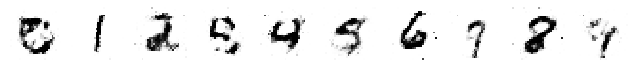

Test losses. G: 1.8754, D: 0.2703
Train Epoch: 29 [0/50000 (0%)]	Losses G: 1.7882, D: 0.3555
Train Epoch: 29 [25000/50000 (50%)]	Losses G: 1.8864, D: 0.4098
Train Epoch: 29 [50000/50000 (100%)]	Losses G: 1.8545, D: 0.4317


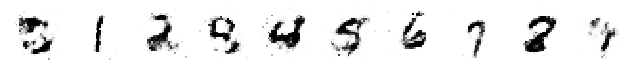

Test losses. G: 1.9251, D: 0.3567
Train Epoch: 30 [0/50000 (0%)]	Losses G: 1.8217, D: 0.4519
Train Epoch: 30 [25000/50000 (50%)]	Losses G: 1.8493, D: 0.3651
Train Epoch: 30 [50000/50000 (100%)]	Losses G: 2.0586, D: 0.3741


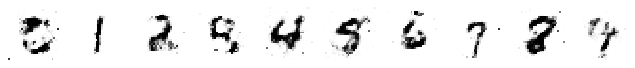

Test losses. G: 2.0250, D: 0.3255
Train Epoch: 31 [0/50000 (0%)]	Losses G: 2.0231, D: 0.4296
Train Epoch: 31 [25000/50000 (50%)]	Losses G: 1.7738, D: 0.5087
Train Epoch: 31 [50000/50000 (100%)]	Losses G: 1.8498, D: 0.4400


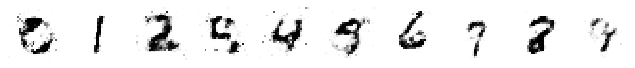

Test losses. G: 1.9478, D: 0.3880
Train Epoch: 32 [0/50000 (0%)]	Losses G: 2.0541, D: 0.4723
Train Epoch: 32 [25000/50000 (50%)]	Losses G: 1.8086, D: 0.3820
Train Epoch: 32 [50000/50000 (100%)]	Losses G: 1.8107, D: 0.4055


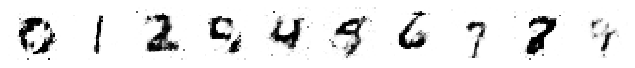

Test losses. G: 1.9268, D: 0.3296
Train Epoch: 33 [0/50000 (0%)]	Losses G: 2.1208, D: 0.4254
Train Epoch: 33 [25000/50000 (50%)]	Losses G: 2.0207, D: 0.4234
Train Epoch: 33 [50000/50000 (100%)]	Losses G: 1.8811, D: 0.4524


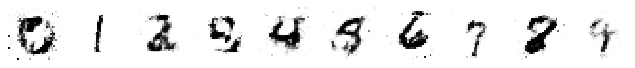

Test losses. G: 1.8740, D: 0.3479
Train Epoch: 34 [0/50000 (0%)]	Losses G: 1.7021, D: 0.4058
Train Epoch: 34 [25000/50000 (50%)]	Losses G: 1.7724, D: 0.4513
Train Epoch: 34 [50000/50000 (100%)]	Losses G: 1.8918, D: 0.3963


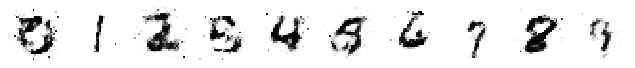

Test losses. G: 1.8969, D: 0.3310
Train Epoch: 35 [0/50000 (0%)]	Losses G: 1.8842, D: 0.3834
Train Epoch: 35 [25000/50000 (50%)]	Losses G: 1.7825, D: 0.3962
Train Epoch: 35 [50000/50000 (100%)]	Losses G: 1.9796, D: 0.4167


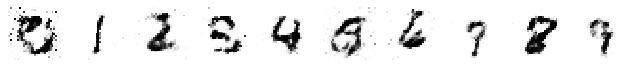

Test losses. G: 2.0515, D: 0.3486
Train Epoch: 36 [0/50000 (0%)]	Losses G: 2.2637, D: 0.4130
Train Epoch: 36 [25000/50000 (50%)]	Losses G: 2.0769, D: 0.3853
Train Epoch: 36 [50000/50000 (100%)]	Losses G: 1.7279, D: 0.4225


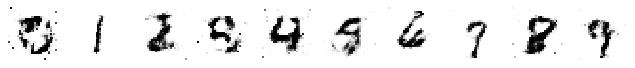

Test losses. G: 1.7093, D: 0.3424
Train Epoch: 37 [0/50000 (0%)]	Losses G: 1.8609, D: 0.4334
Train Epoch: 37 [25000/50000 (50%)]	Losses G: 1.7503, D: 0.4740
Train Epoch: 37 [50000/50000 (100%)]	Losses G: 1.9346, D: 0.3639


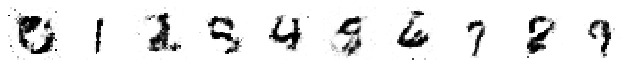

Test losses. G: 1.9174, D: 0.3013
Train Epoch: 38 [0/50000 (0%)]	Losses G: 2.1309, D: 0.3936
Train Epoch: 38 [25000/50000 (50%)]	Losses G: 1.7163, D: 0.4878
Train Epoch: 38 [50000/50000 (100%)]	Losses G: 1.8442, D: 0.4148


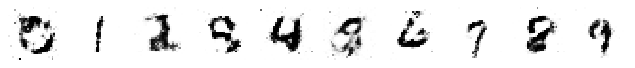

Test losses. G: 1.7954, D: 0.3516
Train Epoch: 39 [0/50000 (0%)]	Losses G: 1.9231, D: 0.4114
Train Epoch: 39 [25000/50000 (50%)]	Losses G: 2.2060, D: 0.4147
Train Epoch: 39 [50000/50000 (100%)]	Losses G: 1.8975, D: 0.3901


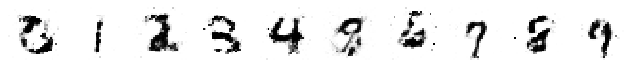

Test losses. G: 1.7907, D: 0.3431
Train Epoch: 40 [0/50000 (0%)]	Losses G: 1.9217, D: 0.3978
Train Epoch: 40 [25000/50000 (50%)]	Losses G: 1.3615, D: 0.4754
Train Epoch: 40 [50000/50000 (100%)]	Losses G: 1.9623, D: 0.3648


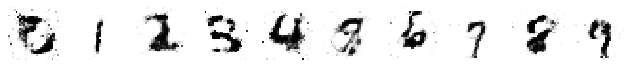

Test losses. G: 1.9700, D: 0.3344
Train Epoch: 41 [0/50000 (0%)]	Losses G: 1.8963, D: 0.3835
Train Epoch: 41 [25000/50000 (50%)]	Losses G: 1.7737, D: 0.4277
Train Epoch: 41 [50000/50000 (100%)]	Losses G: 1.6263, D: 0.3965


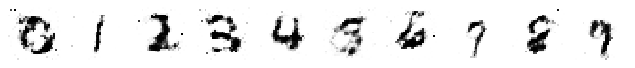

Test losses. G: 1.6632, D: 0.3189
Train Epoch: 42 [0/50000 (0%)]	Losses G: 1.7699, D: 0.3888
Train Epoch: 42 [25000/50000 (50%)]	Losses G: 1.9372, D: 0.3690
Train Epoch: 42 [50000/50000 (100%)]	Losses G: 1.8235, D: 0.4458


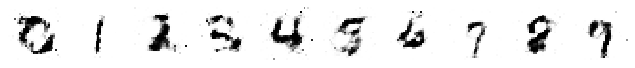

Test losses. G: 1.8050, D: 0.3652
Train Epoch: 43 [0/50000 (0%)]	Losses G: 1.7000, D: 0.4285
Train Epoch: 43 [25000/50000 (50%)]	Losses G: 1.7182, D: 0.4512
Train Epoch: 43 [50000/50000 (100%)]	Losses G: 1.6612, D: 0.4140


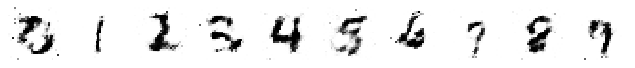

Test losses. G: 1.7111, D: 0.3549
Train Epoch: 44 [0/50000 (0%)]	Losses G: 1.5883, D: 0.4035
Train Epoch: 44 [25000/50000 (50%)]	Losses G: 1.8706, D: 0.4449
Train Epoch: 44 [50000/50000 (100%)]	Losses G: 1.5786, D: 0.4592


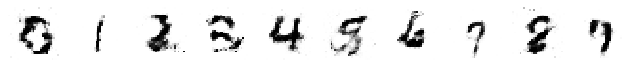

Test losses. G: 1.5762, D: 0.3949
Train Epoch: 45 [0/50000 (0%)]	Losses G: 1.4132, D: 0.4630
Train Epoch: 45 [25000/50000 (50%)]	Losses G: 1.8429, D: 0.4458
Train Epoch: 45 [50000/50000 (100%)]	Losses G: 1.6188, D: 0.5003


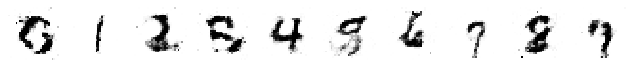

Test losses. G: 1.4640, D: 0.3758
Train Epoch: 46 [0/50000 (0%)]	Losses G: 1.3511, D: 0.4362
Train Epoch: 46 [25000/50000 (50%)]	Losses G: 1.6011, D: 0.4694
Train Epoch: 46 [50000/50000 (100%)]	Losses G: 1.8216, D: 0.4848


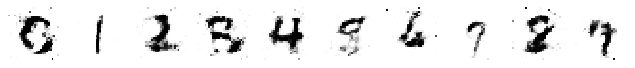

Test losses. G: 1.6876, D: 0.4028
Train Epoch: 47 [0/50000 (0%)]	Losses G: 1.4558, D: 0.5414
Train Epoch: 47 [25000/50000 (50%)]	Losses G: 1.0856, D: 0.4962
Train Epoch: 47 [50000/50000 (100%)]	Losses G: 1.5081, D: 0.5033


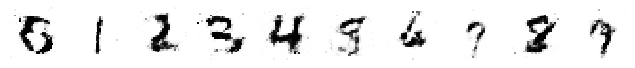

Test losses. G: 1.4598, D: 0.4339
Train Epoch: 48 [0/50000 (0%)]	Losses G: 1.5113, D: 0.4730
Train Epoch: 48 [25000/50000 (50%)]	Losses G: 1.5922, D: 0.4371
Train Epoch: 48 [50000/50000 (100%)]	Losses G: 1.8571, D: 0.4486


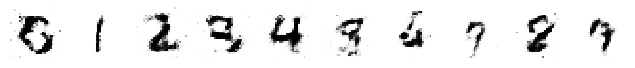

Test losses. G: 1.8063, D: 0.3795
Train Epoch: 49 [0/50000 (0%)]	Losses G: 1.7168, D: 0.4266
Train Epoch: 49 [25000/50000 (50%)]	Losses G: 1.7207, D: 0.4384
Train Epoch: 49 [50000/50000 (100%)]	Losses G: 1.9031, D: 0.4394


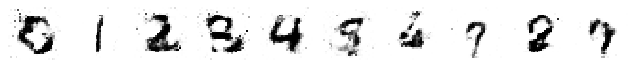

Test losses. G: 2.0026, D: 0.3653
Train Epoch: 50 [0/50000 (0%)]	Losses G: 1.6767, D: 0.4253
Train Epoch: 50 [25000/50000 (50%)]	Losses G: 1.9371, D: 0.4520
Train Epoch: 50 [50000/50000 (100%)]	Losses G: 1.5906, D: 0.4829


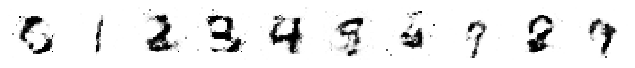

Test losses. G: 1.6082, D: 0.4191
Train Epoch: 51 [0/50000 (0%)]	Losses G: 1.4507, D: 0.5164
Train Epoch: 51 [25000/50000 (50%)]	Losses G: 1.6548, D: 0.4624
Train Epoch: 51 [50000/50000 (100%)]	Losses G: 1.4120, D: 0.4106


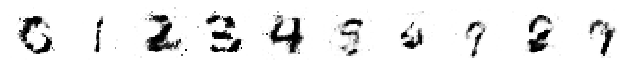

Test losses. G: 1.3991, D: 0.3801
Train Epoch: 52 [0/50000 (0%)]	Losses G: 1.6482, D: 0.4578
Train Epoch: 52 [25000/50000 (50%)]	Losses G: 1.3519, D: 0.4591
Train Epoch: 52 [50000/50000 (100%)]	Losses G: 1.4092, D: 0.5159


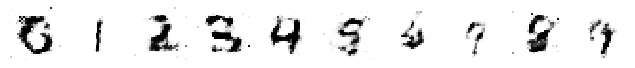

Test losses. G: 1.3340, D: 0.4158
Train Epoch: 53 [0/50000 (0%)]	Losses G: 1.4370, D: 0.4735
Train Epoch: 53 [25000/50000 (50%)]	Losses G: 1.4054, D: 0.4516
Train Epoch: 53 [50000/50000 (100%)]	Losses G: 1.6198, D: 0.5013


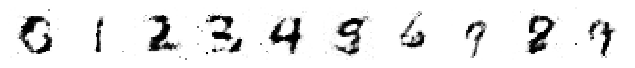

Test losses. G: 1.5981, D: 0.4447
Train Epoch: 54 [0/50000 (0%)]	Losses G: 1.3741, D: 0.5856
Train Epoch: 54 [25000/50000 (50%)]	Losses G: 1.3445, D: 0.5079
Train Epoch: 54 [50000/50000 (100%)]	Losses G: 1.5890, D: 0.4054


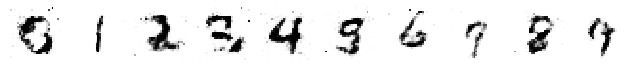

Test losses. G: 1.5869, D: 0.3718
Train Epoch: 55 [0/50000 (0%)]	Losses G: 1.6614, D: 0.4283
Train Epoch: 55 [25000/50000 (50%)]	Losses G: 1.2894, D: 0.5333
Train Epoch: 55 [50000/50000 (100%)]	Losses G: 1.5775, D: 0.4466


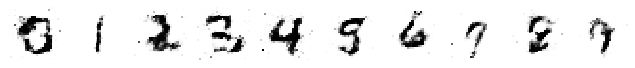

Test losses. G: 1.5257, D: 0.4204
Train Epoch: 56 [0/50000 (0%)]	Losses G: 1.6332, D: 0.4466
Train Epoch: 56 [25000/50000 (50%)]	Losses G: 1.6386, D: 0.4128
Train Epoch: 56 [50000/50000 (100%)]	Losses G: 1.4701, D: 0.4884


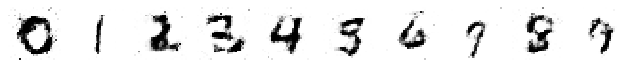

Test losses. G: 1.5444, D: 0.4060
Train Epoch: 57 [0/50000 (0%)]	Losses G: 1.3576, D: 0.4628
Train Epoch: 57 [25000/50000 (50%)]	Losses G: 1.4926, D: 0.5213
Train Epoch: 57 [50000/50000 (100%)]	Losses G: 1.5882, D: 0.5135


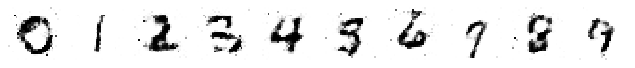

Test losses. G: 1.5821, D: 0.4018
Train Epoch: 58 [0/50000 (0%)]	Losses G: 1.8293, D: 0.4509
Train Epoch: 58 [25000/50000 (50%)]	Losses G: 1.5638, D: 0.4921
Train Epoch: 58 [50000/50000 (100%)]	Losses G: 1.6944, D: 0.4754


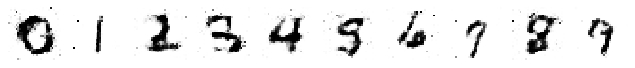

Test losses. G: 1.6499, D: 0.3940
Train Epoch: 59 [0/50000 (0%)]	Losses G: 1.6401, D: 0.4780
Train Epoch: 59 [25000/50000 (50%)]	Losses G: 1.5081, D: 0.4811
Train Epoch: 59 [50000/50000 (100%)]	Losses G: 1.1775, D: 0.5137


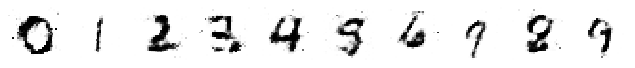

Test losses. G: 1.1616, D: 0.4345
Train Epoch: 60 [0/50000 (0%)]	Losses G: 1.0827, D: 0.5031
Train Epoch: 60 [25000/50000 (50%)]	Losses G: 1.6320, D: 0.4951
Train Epoch: 60 [50000/50000 (100%)]	Losses G: 1.6616, D: 0.4774


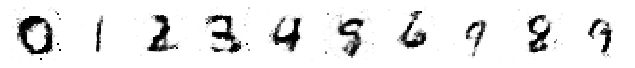

Test losses. G: 1.4466, D: 0.4137
Train Epoch: 61 [0/50000 (0%)]	Losses G: 1.4819, D: 0.4523
Train Epoch: 61 [25000/50000 (50%)]	Losses G: 1.3853, D: 0.5035
Train Epoch: 61 [50000/50000 (100%)]	Losses G: 1.4465, D: 0.4656


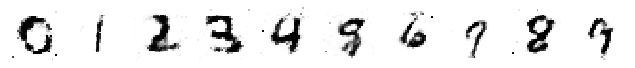

Test losses. G: 1.4747, D: 0.4493
Train Epoch: 62 [0/50000 (0%)]	Losses G: 1.4332, D: 0.5046
Train Epoch: 62 [25000/50000 (50%)]	Losses G: 1.4618, D: 0.5203
Train Epoch: 62 [50000/50000 (100%)]	Losses G: 1.5488, D: 0.5339


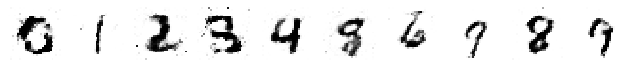

Test losses. G: 1.5627, D: 0.4542
Train Epoch: 63 [0/50000 (0%)]	Losses G: 1.3978, D: 0.5106
Train Epoch: 63 [25000/50000 (50%)]	Losses G: 1.5923, D: 0.4605
Train Epoch: 63 [50000/50000 (100%)]	Losses G: 1.2062, D: 0.5740


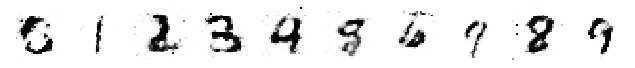

Test losses. G: 1.1638, D: 0.5005
Train Epoch: 64 [0/50000 (0%)]	Losses G: 1.2182, D: 0.5513
Train Epoch: 64 [25000/50000 (50%)]	Losses G: 1.2158, D: 0.5287
Train Epoch: 64 [50000/50000 (100%)]	Losses G: 1.2822, D: 0.5248


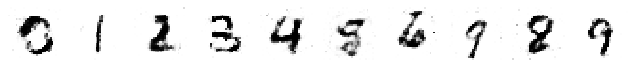

Test losses. G: 1.3701, D: 0.4555
Train Epoch: 65 [0/50000 (0%)]	Losses G: 1.2693, D: 0.4891
Train Epoch: 65 [25000/50000 (50%)]	Losses G: 1.3503, D: 0.5087
Train Epoch: 65 [50000/50000 (100%)]	Losses G: 1.9351, D: 0.4239


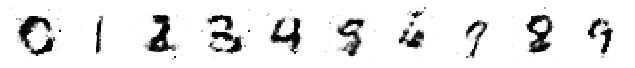

Test losses. G: 1.8311, D: 0.3856
Train Epoch: 66 [0/50000 (0%)]	Losses G: 2.0163, D: 0.4696
Train Epoch: 66 [25000/50000 (50%)]	Losses G: 2.0701, D: 0.4520
Train Epoch: 66 [50000/50000 (100%)]	Losses G: 1.7104, D: 0.5228


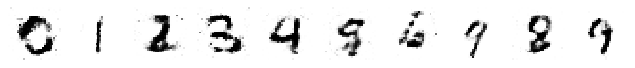

Test losses. G: 1.5469, D: 0.4286
Train Epoch: 67 [0/50000 (0%)]	Losses G: 1.3950, D: 0.5184
Train Epoch: 67 [25000/50000 (50%)]	Losses G: 1.4679, D: 0.5503
Train Epoch: 67 [50000/50000 (100%)]	Losses G: 1.1661, D: 0.5712


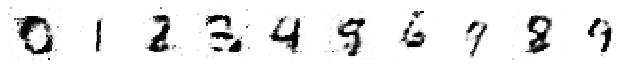

Test losses. G: 1.1935, D: 0.4820
Train Epoch: 68 [0/50000 (0%)]	Losses G: 1.1996, D: 0.5111
Train Epoch: 68 [25000/50000 (50%)]	Losses G: 1.3063, D: 0.4453
Train Epoch: 68 [50000/50000 (100%)]	Losses G: 1.3749, D: 0.5067


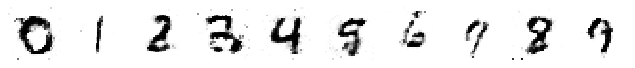

Test losses. G: 1.3677, D: 0.4306
Train Epoch: 69 [0/50000 (0%)]	Losses G: 1.2874, D: 0.4722
Train Epoch: 69 [25000/50000 (50%)]	Losses G: 1.2889, D: 0.5271
Train Epoch: 69 [50000/50000 (100%)]	Losses G: 1.6171, D: 0.4312


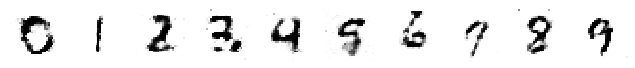

Test losses. G: 1.6771, D: 0.4059
Train Epoch: 70 [0/50000 (0%)]	Losses G: 1.5756, D: 0.5014
Train Epoch: 70 [25000/50000 (50%)]	Losses G: 1.4695, D: 0.5611
Train Epoch: 70 [50000/50000 (100%)]	Losses G: 1.2307, D: 0.5259


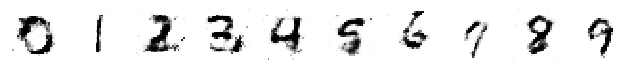

Test losses. G: 1.2863, D: 0.4552
Train Epoch: 71 [0/50000 (0%)]	Losses G: 1.2269, D: 0.5271
Train Epoch: 71 [25000/50000 (50%)]	Losses G: 1.5180, D: 0.4612
Train Epoch: 71 [50000/50000 (100%)]	Losses G: 1.3766, D: 0.4344


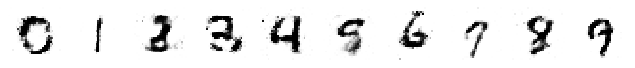

Test losses. G: 1.3933, D: 0.3952
Train Epoch: 72 [0/50000 (0%)]	Losses G: 1.4129, D: 0.4735
Train Epoch: 72 [25000/50000 (50%)]	Losses G: 1.5571, D: 0.4938
Train Epoch: 72 [50000/50000 (100%)]	Losses G: 1.3445, D: 0.5760


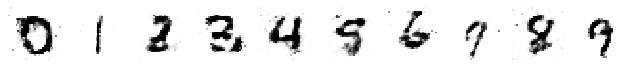

Test losses. G: 1.2688, D: 0.4677
Train Epoch: 73 [0/50000 (0%)]	Losses G: 1.4317, D: 0.5370
Train Epoch: 73 [25000/50000 (50%)]	Losses G: 1.3192, D: 0.4682
Train Epoch: 73 [50000/50000 (100%)]	Losses G: 1.3849, D: 0.4738


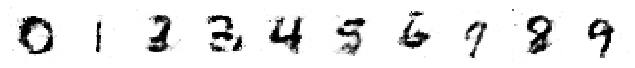

Test losses. G: 1.3402, D: 0.4419
Train Epoch: 74 [0/50000 (0%)]	Losses G: 1.3427, D: 0.4536
Train Epoch: 74 [25000/50000 (50%)]	Losses G: 1.4043, D: 0.4710
Train Epoch: 74 [50000/50000 (100%)]	Losses G: 1.5890, D: 0.4993


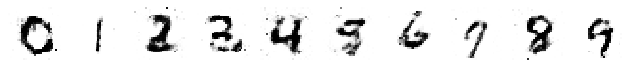

Test losses. G: 1.6109, D: 0.4234
Train Epoch: 75 [0/50000 (0%)]	Losses G: 1.6606, D: 0.4959
Train Epoch: 75 [25000/50000 (50%)]	Losses G: 1.4908, D: 0.4501
Train Epoch: 75 [50000/50000 (100%)]	Losses G: 1.3568, D: 0.5069


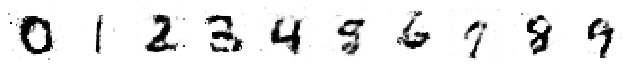

Test losses. G: 1.4213, D: 0.4315
Train Epoch: 76 [0/50000 (0%)]	Losses G: 1.5255, D: 0.4938
Train Epoch: 76 [25000/50000 (50%)]	Losses G: 1.3068, D: 0.5036
Train Epoch: 76 [50000/50000 (100%)]	Losses G: 1.3766, D: 0.4839


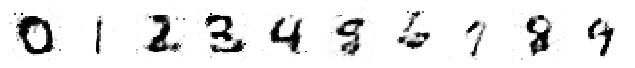

Test losses. G: 1.4266, D: 0.4094
Train Epoch: 77 [0/50000 (0%)]	Losses G: 1.4293, D: 0.4460
Train Epoch: 77 [25000/50000 (50%)]	Losses G: 1.3138, D: 0.5514
Train Epoch: 77 [50000/50000 (100%)]	Losses G: 1.4089, D: 0.5255


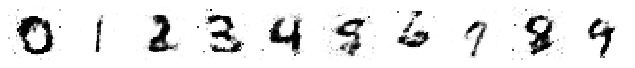

Test losses. G: 1.4305, D: 0.4782
Train Epoch: 78 [0/50000 (0%)]	Losses G: 1.3975, D: 0.5329
Train Epoch: 78 [25000/50000 (50%)]	Losses G: 1.4726, D: 0.4940
Train Epoch: 78 [50000/50000 (100%)]	Losses G: 1.7872, D: 0.4577


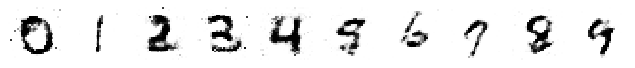

Test losses. G: 1.6535, D: 0.4095
Train Epoch: 79 [0/50000 (0%)]	Losses G: 1.5058, D: 0.4523
Train Epoch: 79 [25000/50000 (50%)]	Losses G: 1.5038, D: 0.4977
Train Epoch: 79 [50000/50000 (100%)]	Losses G: 1.4788, D: 0.5364


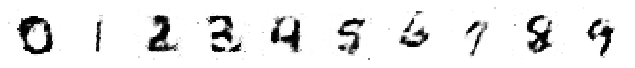

Test losses. G: 1.5187, D: 0.4763
Train Epoch: 80 [0/50000 (0%)]	Losses G: 1.2537, D: 0.5233
Train Epoch: 80 [25000/50000 (50%)]	Losses G: 1.2845, D: 0.5200
Train Epoch: 80 [50000/50000 (100%)]	Losses G: 1.4689, D: 0.4839


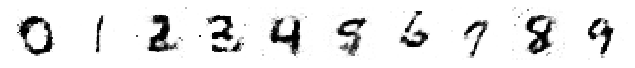

Test losses. G: 1.4960, D: 0.4427
Train Epoch: 81 [0/50000 (0%)]	Losses G: 1.4583, D: 0.4854
Train Epoch: 81 [25000/50000 (50%)]	Losses G: 1.1741, D: 0.5940
Train Epoch: 81 [50000/50000 (100%)]	Losses G: 1.1222, D: 0.5661


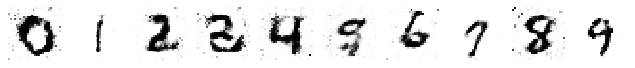

Test losses. G: 1.1282, D: 0.5319
Train Epoch: 82 [0/50000 (0%)]	Losses G: 1.2047, D: 0.6097
Train Epoch: 82 [25000/50000 (50%)]	Losses G: 1.2685, D: 0.5463
Train Epoch: 82 [50000/50000 (100%)]	Losses G: 1.1943, D: 0.4957


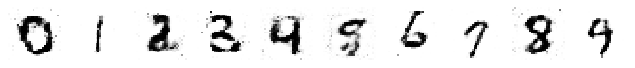

Test losses. G: 1.2158, D: 0.4312
Train Epoch: 83 [0/50000 (0%)]	Losses G: 1.2447, D: 0.4702
Train Epoch: 83 [25000/50000 (50%)]	Losses G: 1.3238, D: 0.5411
Train Epoch: 83 [50000/50000 (100%)]	Losses G: 1.4150, D: 0.5163


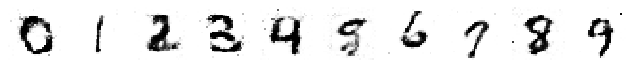

Test losses. G: 1.4618, D: 0.5059
Train Epoch: 84 [0/50000 (0%)]	Losses G: 1.2358, D: 0.5609
Train Epoch: 84 [25000/50000 (50%)]	Losses G: 1.2810, D: 0.5024
Train Epoch: 84 [50000/50000 (100%)]	Losses G: 1.3670, D: 0.5458


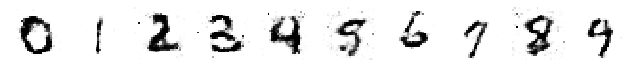

Test losses. G: 1.3239, D: 0.4875
Train Epoch: 85 [0/50000 (0%)]	Losses G: 1.2736, D: 0.4987
Train Epoch: 85 [25000/50000 (50%)]	Losses G: 1.6135, D: 0.4372
Train Epoch: 85 [50000/50000 (100%)]	Losses G: 1.6045, D: 0.5174


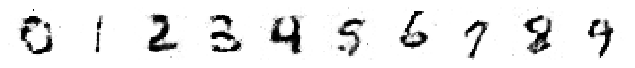

Test losses. G: 1.5118, D: 0.4538
Train Epoch: 86 [0/50000 (0%)]	Losses G: 1.2381, D: 0.5333
Train Epoch: 86 [25000/50000 (50%)]	Losses G: 1.1237, D: 0.5779
Train Epoch: 86 [50000/50000 (100%)]	Losses G: 1.0763, D: 0.5152


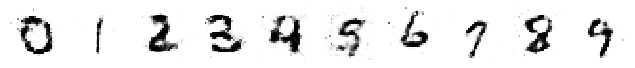

Test losses. G: 1.0882, D: 0.4741
Train Epoch: 87 [0/50000 (0%)]	Losses G: 1.1261, D: 0.4908
Train Epoch: 87 [25000/50000 (50%)]	Losses G: 1.0918, D: 0.6109
Train Epoch: 87 [50000/50000 (100%)]	Losses G: 1.2393, D: 0.5024


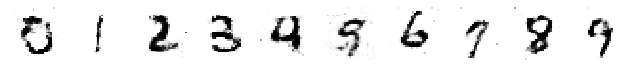

Test losses. G: 1.1501, D: 0.4807
Train Epoch: 88 [0/50000 (0%)]	Losses G: 1.2049, D: 0.5445
Train Epoch: 88 [25000/50000 (50%)]	Losses G: 1.3843, D: 0.5347
Train Epoch: 88 [50000/50000 (100%)]	Losses G: 0.9954, D: 0.5865


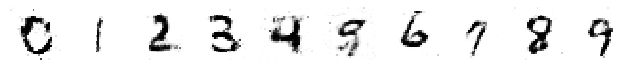

Test losses. G: 0.9806, D: 0.5494
Train Epoch: 89 [0/50000 (0%)]	Losses G: 1.0113, D: 0.6102
Train Epoch: 89 [25000/50000 (50%)]	Losses G: 1.0088, D: 0.5931
Train Epoch: 89 [50000/50000 (100%)]	Losses G: 1.1642, D: 0.5887


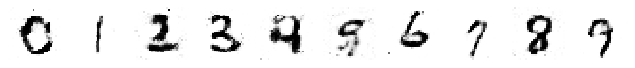

Test losses. G: 1.2182, D: 0.5350
Train Epoch: 90 [0/50000 (0%)]	Losses G: 1.0558, D: 0.6608
Train Epoch: 90 [25000/50000 (50%)]	Losses G: 1.2323, D: 0.5237
Train Epoch: 90 [50000/50000 (100%)]	Losses G: 1.0993, D: 0.5699


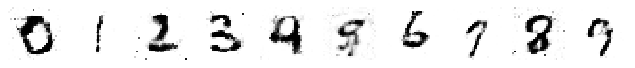

Test losses. G: 1.1002, D: 0.4893
Train Epoch: 91 [0/50000 (0%)]	Losses G: 1.1541, D: 0.5267
Train Epoch: 91 [25000/50000 (50%)]	Losses G: 1.1565, D: 0.4788
Train Epoch: 91 [50000/50000 (100%)]	Losses G: 1.3075, D: 0.5157


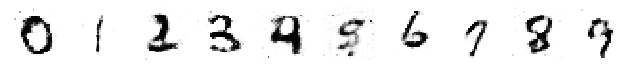

Test losses. G: 1.3204, D: 0.4656
Train Epoch: 92 [0/50000 (0%)]	Losses G: 1.3669, D: 0.5225
Train Epoch: 92 [25000/50000 (50%)]	Losses G: 1.0987, D: 0.5444
Train Epoch: 92 [50000/50000 (100%)]	Losses G: 1.2074, D: 0.5710


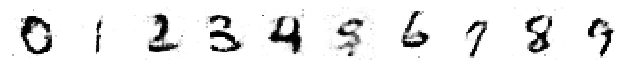

Test losses. G: 1.2374, D: 0.5379
Train Epoch: 93 [0/50000 (0%)]	Losses G: 1.2021, D: 0.5841
Train Epoch: 93 [25000/50000 (50%)]	Losses G: 1.1617, D: 0.5553
Train Epoch: 93 [50000/50000 (100%)]	Losses G: 1.2381, D: 0.5615


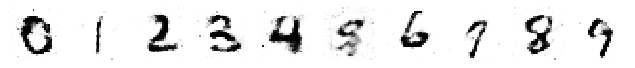

Test losses. G: 1.2591, D: 0.4812
Train Epoch: 94 [0/50000 (0%)]	Losses G: 1.3293, D: 0.5063
Train Epoch: 94 [25000/50000 (50%)]	Losses G: 1.3045, D: 0.5360
Train Epoch: 94 [50000/50000 (100%)]	Losses G: 1.2603, D: 0.4795


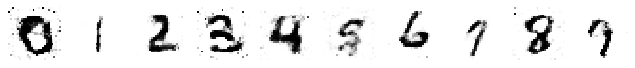

Test losses. G: 1.3765, D: 0.4373
Train Epoch: 95 [0/50000 (0%)]	Losses G: 1.2870, D: 0.4790
Train Epoch: 95 [25000/50000 (50%)]	Losses G: 1.4776, D: 0.5314
Train Epoch: 95 [50000/50000 (100%)]	Losses G: 1.1942, D: 0.5485


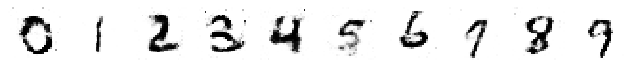

Test losses. G: 1.1148, D: 0.5004
Train Epoch: 96 [0/50000 (0%)]	Losses G: 1.1903, D: 0.5684
Train Epoch: 96 [25000/50000 (50%)]	Losses G: 1.3788, D: 0.5398
Train Epoch: 96 [50000/50000 (100%)]	Losses G: 1.2553, D: 0.5724


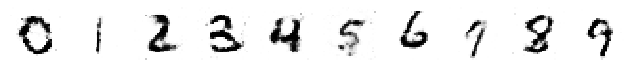

Test losses. G: 1.1649, D: 0.5403
Train Epoch: 97 [0/50000 (0%)]	Losses G: 1.2631, D: 0.5754
Train Epoch: 97 [25000/50000 (50%)]	Losses G: 1.1440, D: 0.5474
Train Epoch: 97 [50000/50000 (100%)]	Losses G: 1.3030, D: 0.4774


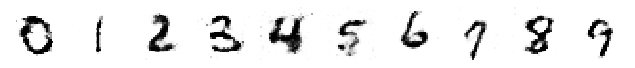

Test losses. G: 1.3189, D: 0.4818
Train Epoch: 98 [0/50000 (0%)]	Losses G: 1.3999, D: 0.5146
Train Epoch: 98 [25000/50000 (50%)]	Losses G: 1.2962, D: 0.5679
Train Epoch: 98 [50000/50000 (100%)]	Losses G: 1.0486, D: 0.5237


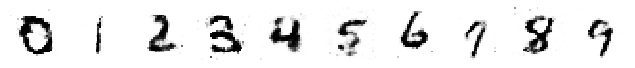

Test losses. G: 1.1226, D: 0.4824
Train Epoch: 99 [0/50000 (0%)]	Losses G: 0.9534, D: 0.5433
Train Epoch: 99 [25000/50000 (50%)]	Losses G: 1.2063, D: 0.5183
Train Epoch: 99 [50000/50000 (100%)]	Losses G: 1.1961, D: 0.5045


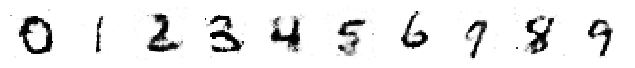

Test losses. G: 1.2303, D: 0.4479
Train Epoch: 100 [0/50000 (0%)]	Losses G: 1.3059, D: 0.4699
Train Epoch: 100 [25000/50000 (50%)]	Losses G: 1.1242, D: 0.5593
Train Epoch: 100 [50000/50000 (100%)]	Losses G: 1.2522, D: 0.5131


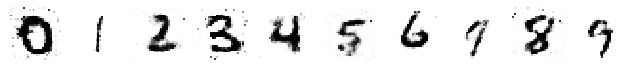

Test losses. G: 1.3093, D: 0.4568
Train Epoch: 101 [0/50000 (0%)]	Losses G: 1.3315, D: 0.5015
Train Epoch: 101 [25000/50000 (50%)]	Losses G: 0.9138, D: 0.5817
Train Epoch: 101 [50000/50000 (100%)]	Losses G: 1.1771, D: 0.5561


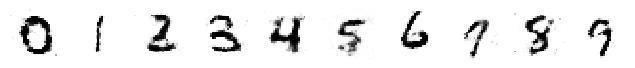

Test losses. G: 1.1453, D: 0.4970
Train Epoch: 102 [0/50000 (0%)]	Losses G: 1.1590, D: 0.5075
Train Epoch: 102 [25000/50000 (50%)]	Losses G: 1.2951, D: 0.5095
Train Epoch: 102 [50000/50000 (100%)]	Losses G: 1.2178, D: 0.5841


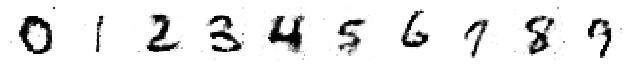

Test losses. G: 1.1937, D: 0.5457
Train Epoch: 103 [0/50000 (0%)]	Losses G: 1.0111, D: 0.5569
Train Epoch: 103 [25000/50000 (50%)]	Losses G: 1.0282, D: 0.5132
Train Epoch: 103 [50000/50000 (100%)]	Losses G: 1.2737, D: 0.4896


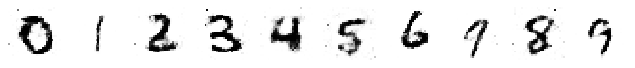

Test losses. G: 1.2758, D: 0.4511
Train Epoch: 104 [0/50000 (0%)]	Losses G: 1.3612, D: 0.4914
Train Epoch: 104 [25000/50000 (50%)]	Losses G: 1.2197, D: 0.4892
Train Epoch: 104 [50000/50000 (100%)]	Losses G: 1.0442, D: 0.6068


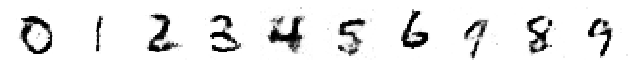

Test losses. G: 1.0978, D: 0.5492
Train Epoch: 105 [0/50000 (0%)]	Losses G: 1.2460, D: 0.6067
Train Epoch: 105 [25000/50000 (50%)]	Losses G: 1.0137, D: 0.5341
Train Epoch: 105 [50000/50000 (100%)]	Losses G: 1.1569, D: 0.5301


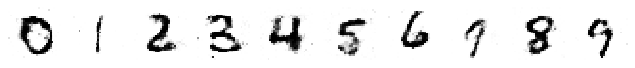

Test losses. G: 1.1845, D: 0.4787
Train Epoch: 106 [0/50000 (0%)]	Losses G: 1.1103, D: 0.4815
Train Epoch: 106 [25000/50000 (50%)]	Losses G: 1.1924, D: 0.5391
Train Epoch: 106 [50000/50000 (100%)]	Losses G: 1.1775, D: 0.5171


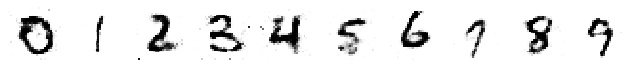

Test losses. G: 1.2002, D: 0.4857
Train Epoch: 107 [0/50000 (0%)]	Losses G: 1.2480, D: 0.5522
Train Epoch: 107 [25000/50000 (50%)]	Losses G: 1.1860, D: 0.5376
Train Epoch: 107 [50000/50000 (100%)]	Losses G: 1.0584, D: 0.5640


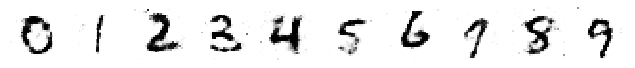

Test losses. G: 1.0720, D: 0.5247
Train Epoch: 108 [0/50000 (0%)]	Losses G: 1.2085, D: 0.5774
Train Epoch: 108 [25000/50000 (50%)]	Losses G: 1.5864, D: 0.5446
Train Epoch: 108 [50000/50000 (100%)]	Losses G: 1.0715, D: 0.5414


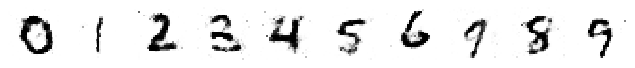

Test losses. G: 1.0697, D: 0.5241
Train Epoch: 109 [0/50000 (0%)]	Losses G: 1.0347, D: 0.5435
Train Epoch: 109 [25000/50000 (50%)]	Losses G: 1.2961, D: 0.5078
Train Epoch: 109 [50000/50000 (100%)]	Losses G: 1.1669, D: 0.5829


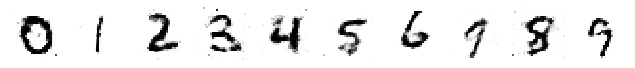

Test losses. G: 1.0895, D: 0.5644
Train Epoch: 110 [0/50000 (0%)]	Losses G: 1.1051, D: 0.6099
Train Epoch: 110 [25000/50000 (50%)]	Losses G: 1.1262, D: 0.5370
Train Epoch: 110 [50000/50000 (100%)]	Losses G: 0.9926, D: 0.6385


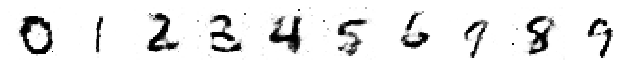

Test losses. G: 1.0323, D: 0.5611
Train Epoch: 111 [0/50000 (0%)]	Losses G: 0.9994, D: 0.5714
Train Epoch: 111 [25000/50000 (50%)]	Losses G: 1.3535, D: 0.5672
Train Epoch: 111 [50000/50000 (100%)]	Losses G: 1.0046, D: 0.5879


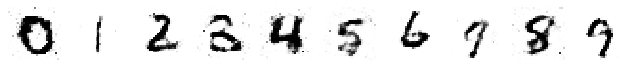

Test losses. G: 1.0657, D: 0.5770
Train Epoch: 112 [0/50000 (0%)]	Losses G: 1.0348, D: 0.6135
Train Epoch: 112 [25000/50000 (50%)]	Losses G: 1.1596, D: 0.5788
Train Epoch: 112 [50000/50000 (100%)]	Losses G: 1.1829, D: 0.5547


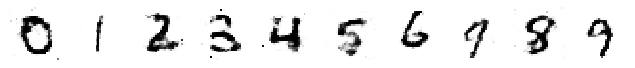

Test losses. G: 1.1468, D: 0.4978
Train Epoch: 113 [0/50000 (0%)]	Losses G: 1.2046, D: 0.5645
Train Epoch: 113 [25000/50000 (50%)]	Losses G: 0.9403, D: 0.5675
Train Epoch: 113 [50000/50000 (100%)]	Losses G: 1.3508, D: 0.5522


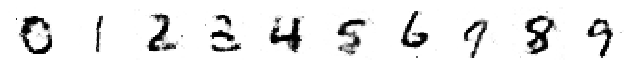

Test losses. G: 1.3580, D: 0.4849
Train Epoch: 114 [0/50000 (0%)]	Losses G: 1.3084, D: 0.4888
Train Epoch: 114 [25000/50000 (50%)]	Losses G: 1.2919, D: 0.5672
Train Epoch: 114 [50000/50000 (100%)]	Losses G: 1.2469, D: 0.5775


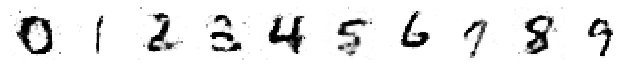

Test losses. G: 1.0687, D: 0.5645
Train Epoch: 115 [0/50000 (0%)]	Losses G: 1.1615, D: 0.6019
Train Epoch: 115 [25000/50000 (50%)]	Losses G: 0.9801, D: 0.5787
Train Epoch: 115 [50000/50000 (100%)]	Losses G: 0.9350, D: 0.5919


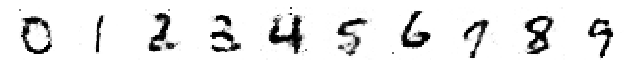

Test losses. G: 1.0004, D: 0.5743
Train Epoch: 116 [0/50000 (0%)]	Losses G: 0.8934, D: 0.6005
Train Epoch: 116 [25000/50000 (50%)]	Losses G: 1.1033, D: 0.5559
Train Epoch: 116 [50000/50000 (100%)]	Losses G: 0.9856, D: 0.5817


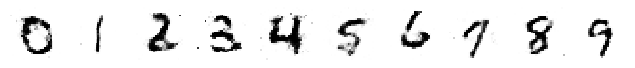

Test losses. G: 0.9818, D: 0.5484
Train Epoch: 117 [0/50000 (0%)]	Losses G: 1.0539, D: 0.5935
Train Epoch: 117 [25000/50000 (50%)]	Losses G: 1.2177, D: 0.5366
Train Epoch: 117 [50000/50000 (100%)]	Losses G: 1.2267, D: 0.5751


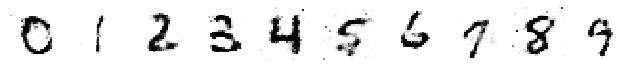

Test losses. G: 1.2183, D: 0.5233
Train Epoch: 118 [0/50000 (0%)]	Losses G: 1.1884, D: 0.5885
Train Epoch: 118 [25000/50000 (50%)]	Losses G: 1.0886, D: 0.6240
Train Epoch: 118 [50000/50000 (100%)]	Losses G: 1.2986, D: 0.5432


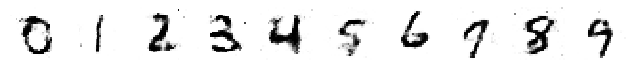

Test losses. G: 1.3031, D: 0.5202
Train Epoch: 119 [0/50000 (0%)]	Losses G: 1.2179, D: 0.5574
Train Epoch: 119 [25000/50000 (50%)]	Losses G: 0.9862, D: 0.5658
Train Epoch: 119 [50000/50000 (100%)]	Losses G: 1.1884, D: 0.5518


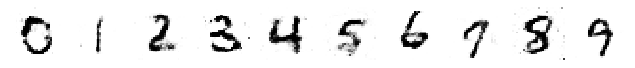

Test losses. G: 1.2411, D: 0.5099
Train Epoch: 120 [0/50000 (0%)]	Losses G: 1.1155, D: 0.5457
Train Epoch: 120 [25000/50000 (50%)]	Losses G: 1.0467, D: 0.5773
Train Epoch: 120 [50000/50000 (100%)]	Losses G: 1.2381, D: 0.5666


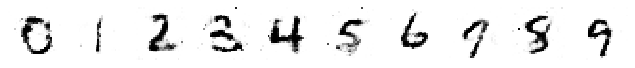

Test losses. G: 1.3070, D: 0.5175
Train Epoch: 121 [0/50000 (0%)]	Losses G: 1.3002, D: 0.5463
Train Epoch: 121 [25000/50000 (50%)]	Losses G: 1.2603, D: 0.5259
Train Epoch: 121 [50000/50000 (100%)]	Losses G: 1.2297, D: 0.5703


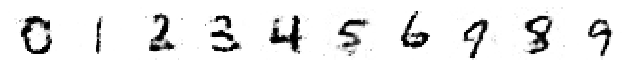

Test losses. G: 1.1992, D: 0.5187
Train Epoch: 122 [0/50000 (0%)]	Losses G: 1.2268, D: 0.5665
Train Epoch: 122 [25000/50000 (50%)]	Losses G: 0.9681, D: 0.5886
Train Epoch: 122 [50000/50000 (100%)]	Losses G: 1.2003, D: 0.5693


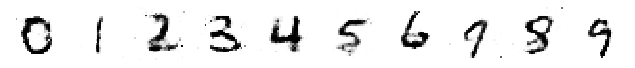

Test losses. G: 1.1408, D: 0.5257
Train Epoch: 123 [0/50000 (0%)]	Losses G: 1.1328, D: 0.5608
Train Epoch: 123 [25000/50000 (50%)]	Losses G: 1.0380, D: 0.6246
Train Epoch: 123 [50000/50000 (100%)]	Losses G: 1.0380, D: 0.6488


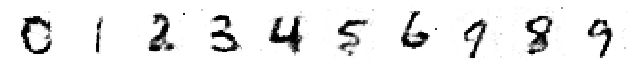

Test losses. G: 0.9989, D: 0.6193
Train Epoch: 124 [0/50000 (0%)]	Losses G: 1.0456, D: 0.6752
Train Epoch: 124 [25000/50000 (50%)]	Losses G: 1.2348, D: 0.5700
Train Epoch: 124 [50000/50000 (100%)]	Losses G: 1.2394, D: 0.5281


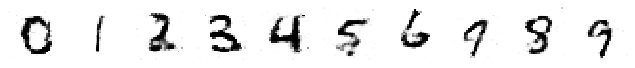

Test losses. G: 1.2389, D: 0.5064
Train Epoch: 125 [0/50000 (0%)]	Losses G: 1.2212, D: 0.5886
Train Epoch: 125 [25000/50000 (50%)]	Losses G: 1.1155, D: 0.6440
Train Epoch: 125 [50000/50000 (100%)]	Losses G: 1.1339, D: 0.5437


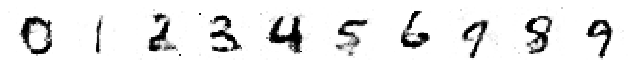

Test losses. G: 1.1294, D: 0.5242
Train Epoch: 126 [0/50000 (0%)]	Losses G: 1.1469, D: 0.5677
Train Epoch: 126 [25000/50000 (50%)]	Losses G: 1.0230, D: 0.5283
Train Epoch: 126 [50000/50000 (100%)]	Losses G: 1.2567, D: 0.5458


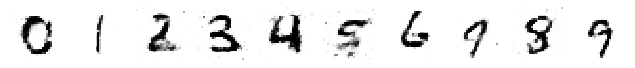

Test losses. G: 1.2348, D: 0.5211
Train Epoch: 127 [0/50000 (0%)]	Losses G: 1.1085, D: 0.5726
Train Epoch: 127 [25000/50000 (50%)]	Losses G: 0.9742, D: 0.6359
Train Epoch: 127 [50000/50000 (100%)]	Losses G: 1.5631, D: 0.5343


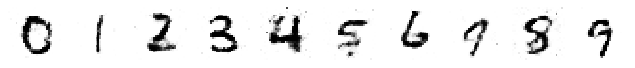

Test losses. G: 1.4971, D: 0.5129
Train Epoch: 128 [0/50000 (0%)]	Losses G: 1.3165, D: 0.5736
Train Epoch: 128 [25000/50000 (50%)]	Losses G: 0.9300, D: 0.6684
Train Epoch: 128 [50000/50000 (100%)]	Losses G: 0.9148, D: 0.6061


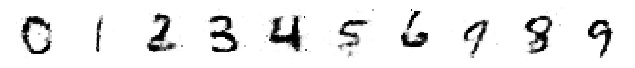

Test losses. G: 0.9700, D: 0.5958
Train Epoch: 129 [0/50000 (0%)]	Losses G: 0.9286, D: 0.6137
Train Epoch: 129 [25000/50000 (50%)]	Losses G: 1.1867, D: 0.5391
Train Epoch: 129 [50000/50000 (100%)]	Losses G: 1.2313, D: 0.5444


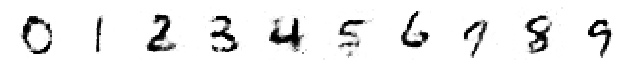

Test losses. G: 1.1801, D: 0.5356
Train Epoch: 130 [0/50000 (0%)]	Losses G: 1.2236, D: 0.5398
Train Epoch: 130 [25000/50000 (50%)]	Losses G: 0.9562, D: 0.6101
Train Epoch: 130 [50000/50000 (100%)]	Losses G: 1.0180, D: 0.6156


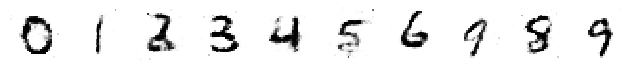

Test losses. G: 0.9973, D: 0.5867
Train Epoch: 131 [0/50000 (0%)]	Losses G: 0.9243, D: 0.6542
Train Epoch: 131 [25000/50000 (50%)]	Losses G: 1.5672, D: 0.5120
Train Epoch: 131 [50000/50000 (100%)]	Losses G: 1.1211, D: 0.6135


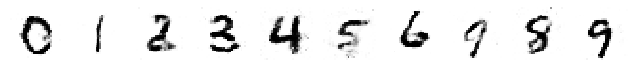

Test losses. G: 1.0811, D: 0.6163
Train Epoch: 132 [0/50000 (0%)]	Losses G: 1.0079, D: 0.6609
Train Epoch: 132 [25000/50000 (50%)]	Losses G: 0.9886, D: 0.6177
Train Epoch: 132 [50000/50000 (100%)]	Losses G: 1.0474, D: 0.5840


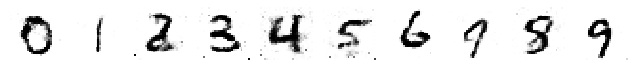

Test losses. G: 1.0505, D: 0.5514
Train Epoch: 133 [0/50000 (0%)]	Losses G: 1.0181, D: 0.5855


KeyboardInterrupt: ignored

In [0]:
for epoch in range(1, 200):
    G.train()
    D.train()
    train(epoch, G, D, train_log)
    G.eval()
    D.eval()
    test(G, D, valid_loader, epoch, test_log)